<a href="https://colab.research.google.com/github/yohanesnuwara/DASLab/blob/main/notebooks/DASSignalNoise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The purpose of this notebook is to demonstrate the calculation of background noise level, signal-to-noise ratio (SNR) analysis, and to explore trace operations such as stacking and integration to improve SNR

In [ ]:
# Install libraries in Colab
!pip install -q utm
!pip install -q nptdms==0.25.0 # Older version
!pip install -q obspy

# Import routine libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from scipy import signal, stats
import pandas as pd

# Plot formatting
plt.rcParams["font.size"] = 20
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

from nptdms import TdmsFile
import utm

In [ ]:
# Access DASLab repository
!git clone 'https://github.com/yohanesnuwara/DASLab'

import sys
sys.path.append('/content/DASLab')

from TDMS_Functions import *
from signalprocessing import *
from autopick import *
from dasplot import *

fatal: destination path 'DASLab' already exists and is not an empty directory.


In [ ]:
# Connect to Goo Drive to access data
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g7BQ2BHHwzk4oXTNaqIvhDBV_XG7izeeCppyXWGjw1K8KcPCIdKKck
Mounted at /content/drive


In [ ]:
import pickle

def loadPkl(filename):
  with open(filename,'rb') as f:
    return pickle.load(f)

In [ ]:
from scipy import integrate

def integrateSignal(t, y, initial=0):
  return integrate.cumtrapz(y, t, initial=initial)

def SNR(t, data, t_init_signal, t_init_noise, t_window=1):
  """
  Calculate Signal-to-Noise Ratio 

  INPUT:

  t: Time samples of trace (1D array)
  data: Trace data (1D array)
  t_init_signal: Initial time of signal (float)
  t_init_noise: Initial time of noise (float)
  t_window: Time window of selected signal and noise part (float). 
    Default is 1 second.

  OUTPUT:

  snr: Signal-to-noise ratio (decibel, db)
  """
  # Cut trace window of signal and noise
  cut_sig = (t_init_signal, t_init_signal+t_window)
  cut_noi = (t_init_noise, t_init_noise+t_window)
  t_sig, y_sig = cutData1D(t, data, cut_sig)
  t_noi, y_noi = cutData1D(t, data, cut_noi)

  # Calculate power of signal (NOTE: Not RMS of signal)
  ps = np.sum(y_sig**2)
  pn = np.sum(y_noi**2)
  ps_db = 10 * np.log10(ps)
  pn_db = 10 * np.log10(pn)

  # Calculate SNR
  snr_db = ps_db - pn_db
  # snr_db = 10 * np.log10(snr)
  return ps_db, pn_db, snr_db

In [ ]:
# Takes 1 minute to load all 8 files from pickle. Takes nearly half the Colab RAM.
dir = "/content/drive/MyDrive/RITE_Yohanes/Pickles/"
n_events = 8 # Number of events to load

stc, hwc, bc = [], [], []
for i in range(n_events):
  filename = dir+'file'+'{}'.format(i+1)+'.pkl'
  f = loadPkl(filename)
  stc.append(f[:,:246])
  hwc.append(f[:,246:246+277])
  bc.append(f[:,246+277:246+277+737])

In [ ]:
bc = np.array(bc)
hwc = np.array(hwc)
stc = np.array(stc)

# Combine all events
ne, nt, nz = np.shape(bc)
bc_all = np.reshape(bc, (ne*nt,nz))

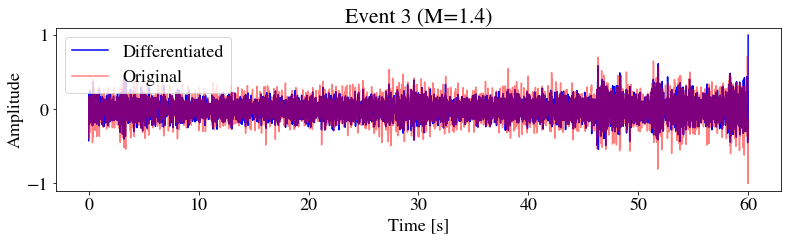

In [ ]:
no_event = 3
no_chann = 100

data = bc[no_event-1,:,:]
y = data[:,no_chann-1]

# Make time array (this is not the true time, combination of events)
ts = 0.001 # Sampling interval
t = np.arange(0,ts*nt,ts) 

# Integrate signal
y_int = integrateSignal(y, t, initial=0)

# Differentiate signal
n = 1
y_diff = np.diff(normalize1D(y), n=n)

# Plot 
plt.figure(figsize=(13,3))
# plt.plot(t, normalize1D(y_int), color='blue', label='Integrated')
plt.plot(t[n:], normalize1D(y_diff), color='blue', label='Differentiated')
plt.plot(t, normalize1D(y), color='red', label='Original', alpha=0.5)
# plt.plot(t, y, color='black')

## Noise floor
# plt.axhline(10, ls='--', color='red', lw=1, label='Noise Floor')
# plt.axhline(-10, ls='--', color='red', lw=1)

# plt.xlim(40,58)
# plt.ylim(-0.5,0.5)
plt.title('Event 3 (M=1.4)')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [ ]:
print(SNR(t, y_diff, 45.5, 2))
print(SNR(t, y, 45.5, 2))

(-4.412804879959868, -8.1044115919938626, 3.6916067120339946)
(48.248137285230953, 46.297067928552536, 1.951069356678417)


Noise level of one event.

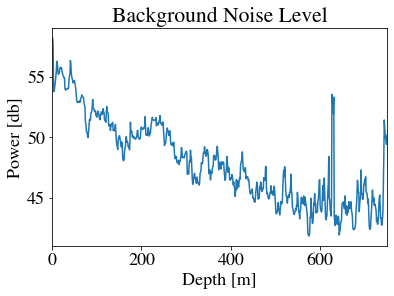

In [ ]:
no_event = 1

data = bc[no_event-1,:,:]
nt, nz = data.shape

# Make depth array
dz = 1.019
z = np.arange(0,dz*nz, dz)

# Make time array (this is not the true time, combination of events)
ts = 0.001 # Sampling interval
t = np.arange(0,ts*nt,ts) 

# Noise level
sl, nl = [], []
for i in range(nz):
  s, n, snr = SNR(t, data[:,i], 45.5, 2, 2)
  sl.append(s)
  nl.append(n)

# Plot noise level across depth
plt.plot(z, nl)
plt.xlim(min(z), max(z))
plt.title('Background Noise Level')
plt.xlabel('Depth [m]')
plt.ylabel('Power [db]')
plt.show()

Average noise/signal/SNR level of all events

$$SNR=20 \log \frac{P_{S_{(t_p,t_p+1)}}}{P_{N_{(0,10)}}}$$

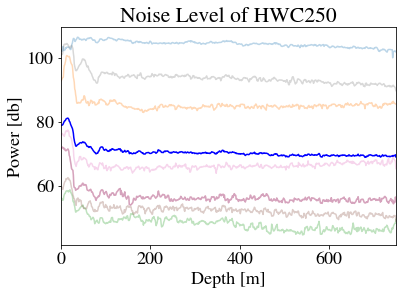

In [ ]:
das = bc

data = das[0,:,:]
nt, nz = data.shape

# Make depth array
dz = 1.019
z = np.arange(0,dz*nz, dz)

# Make time array (this is not the true time, combination of events)
ts = 0.001 # Sampling interval
t = np.arange(0,ts*nt,ts) 

# Arrival of all channels (except channel 5)
arrival = [13.8, 42.4, 45.5, 58.5, 58.5, 46.6, 16.25, 28]

# Average noise level
noise_level = []
for k in range(8):
  event = k+1
  if event!=5:
    # Except event 5 because it's connected to event 4
    data = das[event-1,:,:]

  # Noise level
  nl = []
  for i in range(nz):
    # s, n, snr = SNR(t, data[:,i], 45.5, 2, 2)
    s, n, snr = SNR(t, data[:,i], arrival[k], 2, 1)
    nl.append(s)
  
  # Plot noise level per event
  plt.plot(z, nl, alpha=0.3)

  noise_level.append(nl)

# Average noise level of all events
noise_level = np.mean(noise_level, axis=0)

# Plot noise level across depth
plt.plot(z, noise_level, color='blue')
# plt.yscale('log')
plt.xlim(min(z), max(z))
# plt.ylim(60,80)
plt.title('Noise Level of HWC250')
plt.xlabel('Depth [m]')
plt.ylabel('Power [db]')

plt.show()

In [ ]:

# Plot noise level across depth
plt.plot(z, noise_level, color='blue')
# plt.yscale('log')
plt.xlim(min(z), max(z))
# plt.ylim(ymax=80)
plt.title('Background Noise Level of BC880')
plt.xlabel('Depth [m]')
plt.ylabel('Power [db]')


Channel 48, 228, 551, 736

In [ ]:
import plotly.express as px

chann_no = np.arange(nz)
fig = px.line(x=chann_no, y=noise_level)
fig.show()

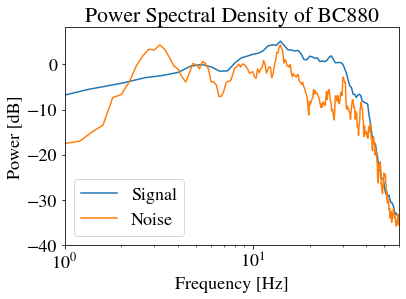

In [ ]:
no_event = 3
no_chann = 300

data = bc[no_event-1,:,:]
y = data[:,no_chann-1]

# Make time array (this is not the true time, combination of events)
ts = 0.001 # Sampling interval
t = np.arange(0,ts*nt,ts) 

tcut, ynoi = cutData1D(t, y, cut_trace=(10,15))
tcut, ysig = cutData1D(t, y, cut_trace=(45.5,47))

frqs_noi, psd_noi = fftSpectrum(ynoi, fs=1/0.001, window=6, output='psd', output_unit='db', plot=False)
frqs_sig, psd_sig = fftSpectrum(ysig, fs=1/0.001, window=10, output='psd', output_unit='db', plot=False)

# Plot spectrum of signal and noise
plt.plot(frqs_sig, psd_sig, label='Signal')
plt.plot(frqs_noi, psd_noi, label='Noise')
plt.xscale('log')
plt.xlim(1,60)
plt.ylim(ymin=-40)
plt.title('Power Spectral Density of BC880')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power [dB]')

# plt.grid(True, which='both')
plt.legend()
plt.show()

In [ ]:
import tqdm.notebook as tq

def stack(data, nostack=10, method='mean', weight_exponent=1):
  m, n = data.shape

  data_stack = []

  print('Stacking in progress ...')  
  progress_bar = tq.tqdm(range(nostack,n))

  for i in progress_bar:
    progress_bar.update()
    y = data[:,i-nostack:i]
    if method=='mean':
      y = [np.mean(y[j,:]) for j in range(m)]

    if method=='median':
      y = [np.median(y[j,:]) for j in range(m)]

    if method=='weighted_mean':
      # Create weight vector. Weights from 0 to 1. Largest weight is the last chann
      # Add exponent. Exponent 1 means linear, exponent >1 means exponential.
      # w = (np.arange(1,nostack+1,1)/nostack)**weight_exponent
      w = np.arange(1,nostack+1,1)**weight_exponent
      w = np.reshape(w, (-1,1))
      w = np.transpose(w)

      # Multiply channels with each weight.       
      y = y * w 
      y = [np.median(y[j,:]) for j in range(m)]    

    data_stack.append(y)        
  print('Stacking completed.')
  
  data_stack = np.transpose(data_stack)
  
  # Zero padding
  zeropad = np.zeros((m, nostack))
  data_stack = np.hstack((zeropad, data_stack))  

  return data_stack

# yy = stack(data[:,:150], nostack=100)

Stacking in progress ...



Stacking completed.


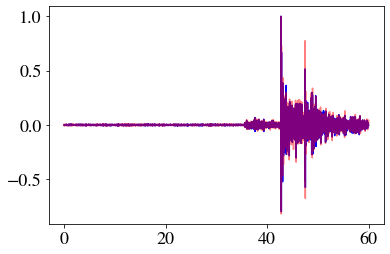

In [ ]:
no_event = 2
stack_chann = 300
nostack = 10

data = bc[no_event-1,:,:]

stack_chann = stack_chann - 1

# Stacking 100 channels before channel No. 600
st = stack(data[:,stack_chann-(nostack+1):stack_chann], nostack=nostack, 
           method='weighted_mean', weight_exponent=2)
st = st[:,-1] # 1D array

# Plot stack
plt.plot(t, normalize1D(st), color='blue')

# Plot channel true record
y = data[:,stack_chann]
plt.plot(t, normalize1D(y), color='red', alpha=0.5)

plt.show()

In [ ]:
print(SNR(t, st, 13.8, 2, 5))
print(SNR(t, y, 13.8, 2, 5))

(83.148768849806885, 82.464467512165797, 0.68430133764108803)
(53.628754806604775, 52.662734070175858, 0.96602073642891639)


In [ ]:
print(SNR(t, st, 45.5, 2, 5))
print(SNR(t, y, 45.5, 2, 5))

(45.421836887233212, 44.764960743095806, 0.65687614413740647)
(53.548921370531161, 52.160241739766455, 1.388679630764706)


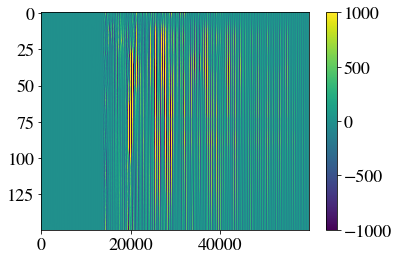

In [ ]:
no_event = 1
no_chann = 600

data = bc[no_event-1,:,:]

plt.imshow(data[:,:150].T, aspect='auto', vmin=-1000, vmax=1000)
plt.colorbar()

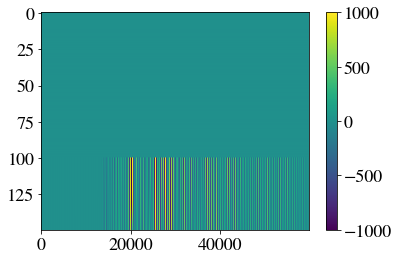

In [ ]:
plt.imshow(yy.T, aspect='auto', vmin=-1000, vmax=1000)
plt.colorbar()

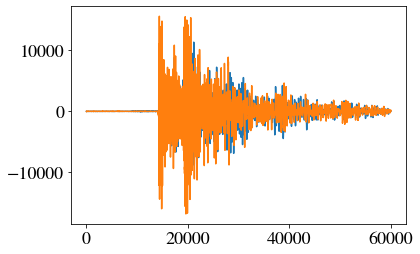

In [ ]:
plt.plot(yy[:,100])
plt.plot(data[:,100])
# plt.plot(yy[:,130])

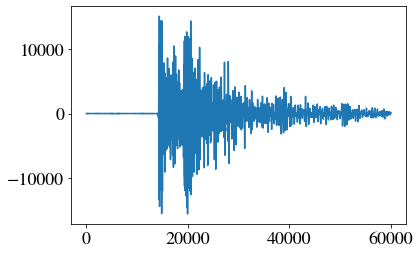

In [ ]:
yi = data[:,100:110]
m, n = yi.shape
# yi[10000,:]
x = [np.mean(yi[i,:]) for i in range(m)]

plt.plot(x)
# plt.plot(data[:,110])